In [1]:
from collections import defaultdict
from tqdm import tqdm
from  pystempel import Stemmer
import pandas as pd
import os
import time
import morfeusz2

import matplotlib.pyplot as plt
%matplotlib inline

## Test dataset 

In [2]:
def read_rules(fpath):
    rules = {}
    with open(fpath, 'r', encoding='utf-8') as lines:
        for line in lines:
            fields = line.strip().split(' ')
            lemma = fields[0]
            forms = fields[1:]
            rules[lemma] = set(forms)
    return rules

In [3]:
rules = morfeusz2.load_dict('dicts/polimorf-20190818.tab.gz')
all_forms = defaultdict(set)
for lemma, forms in tqdm(rules.items(), desc='Stats for rules'):
    for form in forms:
        all_forms[form].add(lemma)
ambiguous_forms = [form for form in all_forms.keys() if len(all_forms[form])>1]
print('All cases: {}'.format(len(rules.keys())))
print('All forms: {}'.format(len(all_forms)))
print('Ambiguous forms: {} ({:.0%})'.format(len(ambiguous_forms), len(ambiguous_forms)/len(all_forms)))

Loading dict: 7381663it [00:14, 501070.60it/s]
Stats for rules: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323681/323681 [00:14<00:00, 22653.81it/s]


All cases: 323681
All forms: 4917282
Ambiguous forms: 151539 (3%)


## Evaluation

In [4]:
def eval(stem, rules):
    cases = rules.keys()
    total_cases = len(cases)
    total_words = 0
    no_stem_found = 0
    valid_lemma = 0
    unique_stem = 0
    start = time.time()
    for lemma, forms in tqdm(rules.items(), desc='Stemming'):
        stemmed_forms = set()
        for form in forms:
            stemmed = stem(form)
            stemmed_forms.add(stemmed)
            total_words += 1
            if stemmed is None:
                no_stem_found += 1
        if len(stemmed_forms) == 1:
            unique_stem += 1
            stemmed = next(iter(stemmed_forms))
            if stemmed == lemma:
                valid_lemma += 1
    stemming_time_sec = time.time() - start

    result = {
        'unique_stem':unique_stem,
        'unique_stem_frac': unique_stem / total_cases,
        'valid_lemma':valid_lemma,
        'valid_lemma_frac':valid_lemma / unique_stem,
        'no_stem_found': no_stem_found,
        'no_stem_found_frac': no_stem_found /  total_words,
        'stemming_time_sec': stemming_time_sec,
        'stemming_time_per_word' : stemming_time_sec / total_words,
        'words_per_second' : total_words / stemming_time_sec
    }
    return result

In [5]:
stemming_tables = ['src/pystempel/data/original/stemmer_20000.tbl.gz',
                   'src/pystempel/data/polimorf/stemmer_polimorf.tbl.gz'
                  ]

results = []
for stemming_table in stemming_tables:
    start = time.time()
    stemmer = Stemmer.from_file(stemming_table)
    loading_time = time.time() - start
    result = eval(stemmer, rules)
    result['loading_time_sec'] = loading_time
    result['stemming_table'] = stemming_table
    result['stemming_table_size_mb'] = os.stat(stemming_table).st_size / (1024*1024)
    results.append(result)

Stemming: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 323681/323681 [02:45<00:00, 1951.84it/s]


In [6]:
results = pd.DataFrame.from_dict(results)
results.set_index('stemming_table', inplace=True)
results

,unique_stem,unique_stem_frac,valid_lemma,valid_lemma_frac,no_stem_found,no_stem_found_frac,stemming_time_sec,stemming_time_per_word,words_per_second,loading_time_sec,stemming_table_size_mb
stemming_table,,,,,,,,,,,
src/pystempel/data/original/stemmer_20000.tbl.gz,120649,0.372740,83028,0.688178,312,0.000061,126.498529,0.000025,40124.466599,1.490314,0.367842
src/pystempel/data/polimorf/stemmer_polimorf.tbl.gz,283775,0.876712,247315,0.871518,22,0.000004,165.839840,0.000033,30605.950910,12.061594,2.206561


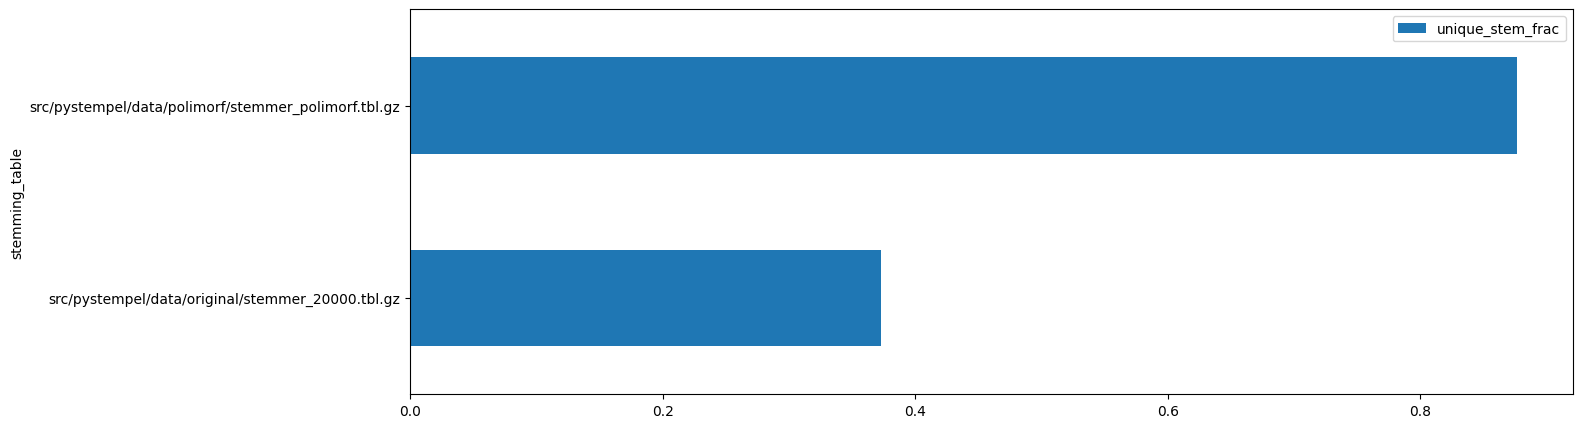

In [7]:
results.plot.barh(y='unique_stem_frac', figsize =(15,5) );

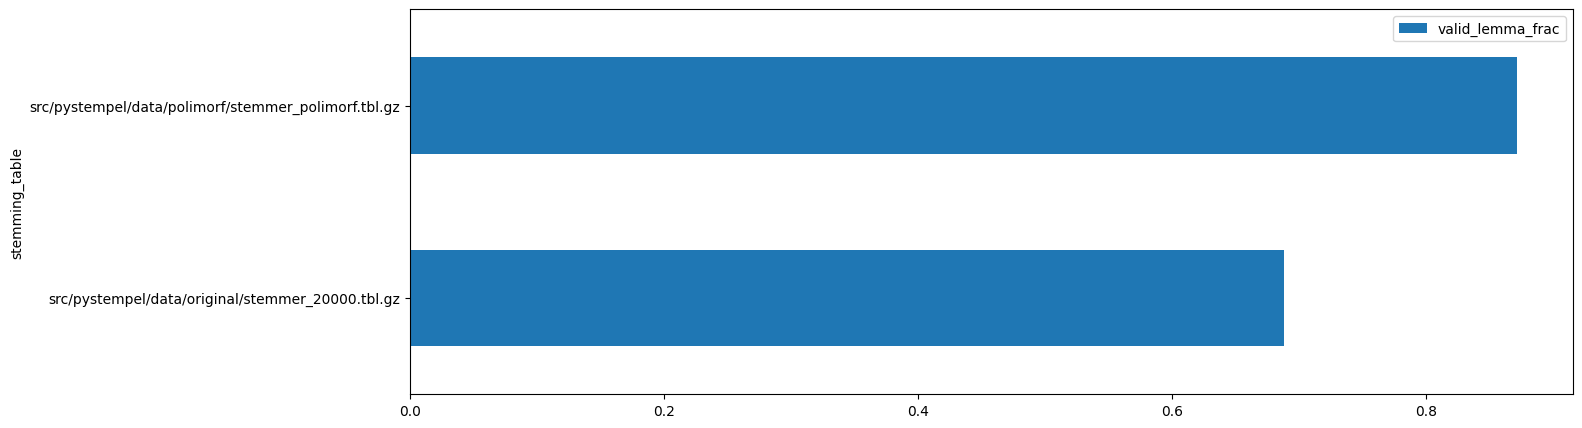

In [8]:
results.plot.barh(y='valid_lemma_frac', figsize =(15,5) );

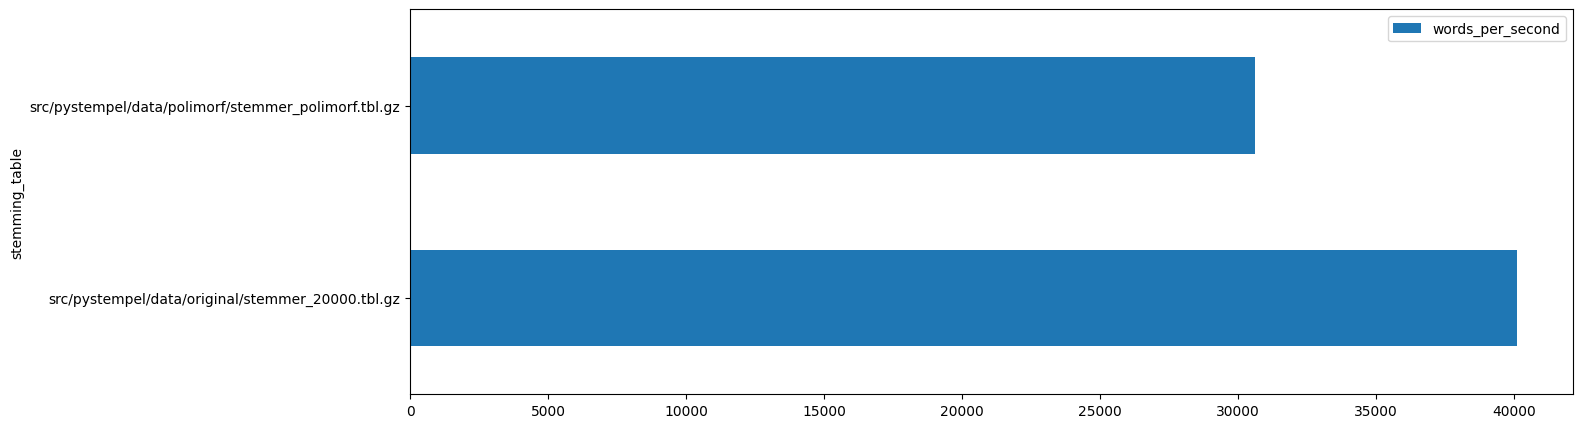

In [9]:
results.plot.barh(y='words_per_second', figsize =(15,5) );

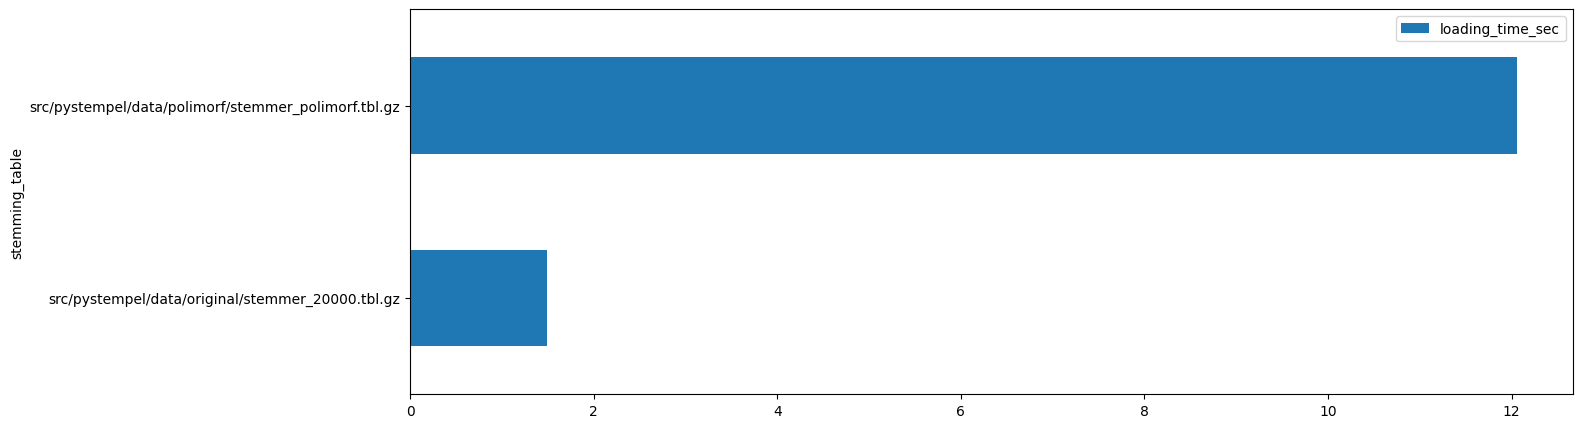

In [10]:
results.plot.barh(y='loading_time_sec', figsize =(15,5) );

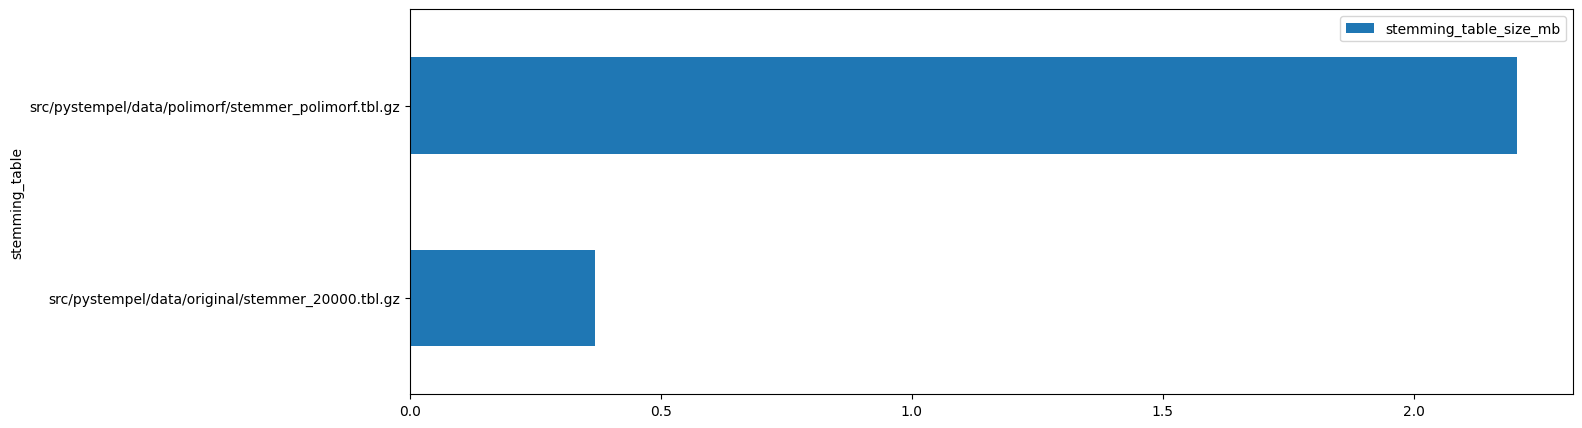

In [11]:
results.plot.barh(y='stemming_table_size_mb', figsize =(15,5) );